<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.ParisHousingPrices/blob/auto_gluon/0_autogluon_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
# Datasets
import pandas as pd
# Numerics
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing & pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Data management
from sklearn.model_selection import train_test_split
# Other
import os

pd.set_option('display.max_columns', None)

In [2]:
%%capture
!pip install autogluon

In [3]:
%%capture
GIT_DOWNLOAD_PATH = 'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'
FILES_LIST = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]
GDRIVE_PATH = '/content/gdrive/MyDrive/'
PREPROC_TRIAL = 'autogluon'
MODELS_TRIAL = 'autogluon'
COMPETITION_PATH = GDRIVE_PATH + 'ML/Competitions/10.ParisHousePrices/'
# --------------------------------------------------
try:
    from nbpep8.nbpep8 import pep8
except ModuleNotFoundError:
    !pip install pycodestyle
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8
# ---------------------------------------
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}
url_dict = {file: GIT_DOWNLOAD_PATH + file for file in FILES_LIST}
print('a')
download_files(url_dict)
# ---------------------------------------
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model
def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)
MODULES_LIST = [
    path_manager,
    sklearn_utils,
    sklearn_transformers,
    model
]
reload_all(MODULES_LIST)
# ---------------------------------------
from path_manager import PathManager
from model import Model
from sklearn_utils import nan_statistics
from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import visualize_datasets_distributions
from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
# ---------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

# Download the data

In [90]:
source_df = pd.read_csv(f'{manager.data_root_path}/train.csv', index_col=0)
submission_df = pd.read_csv(f'{manager.data_root_path}/test.csv', index_col=0)

assert source_df.shape[1] == submission_df.shape[1] + 1, print(source_df.shape, submission_df.shape)
assert set(source_df.columns) - set(submission_df.columns) == {'price'}

source_df.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
id,,,,,,,,,,,,,,,,,
0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


In [91]:
submission_df.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
id,,,,,,,,,,,,,,,,
22730,47580,89,0,1,8,54830,5,3,1995,0,0,6885,8181,241,0,8
22731,62083,38,0,0,87,8576,10,3,1994,1,1,4601,9237,393,1,4
22732,90499,75,1,1,37,62454,9,6,1997,0,1,7454,2680,305,0,2
22733,16354,47,1,1,9,9262,6,5,2019,1,1,705,5097,122,1,5
22734,67510,8,0,0,55,24112,3,7,2014,1,1,3715,7979,401,1,9


# Make sure data is from the same distribution

Visualizing datasets distributions
(6, 3) <class 'numpy.ndarray'>


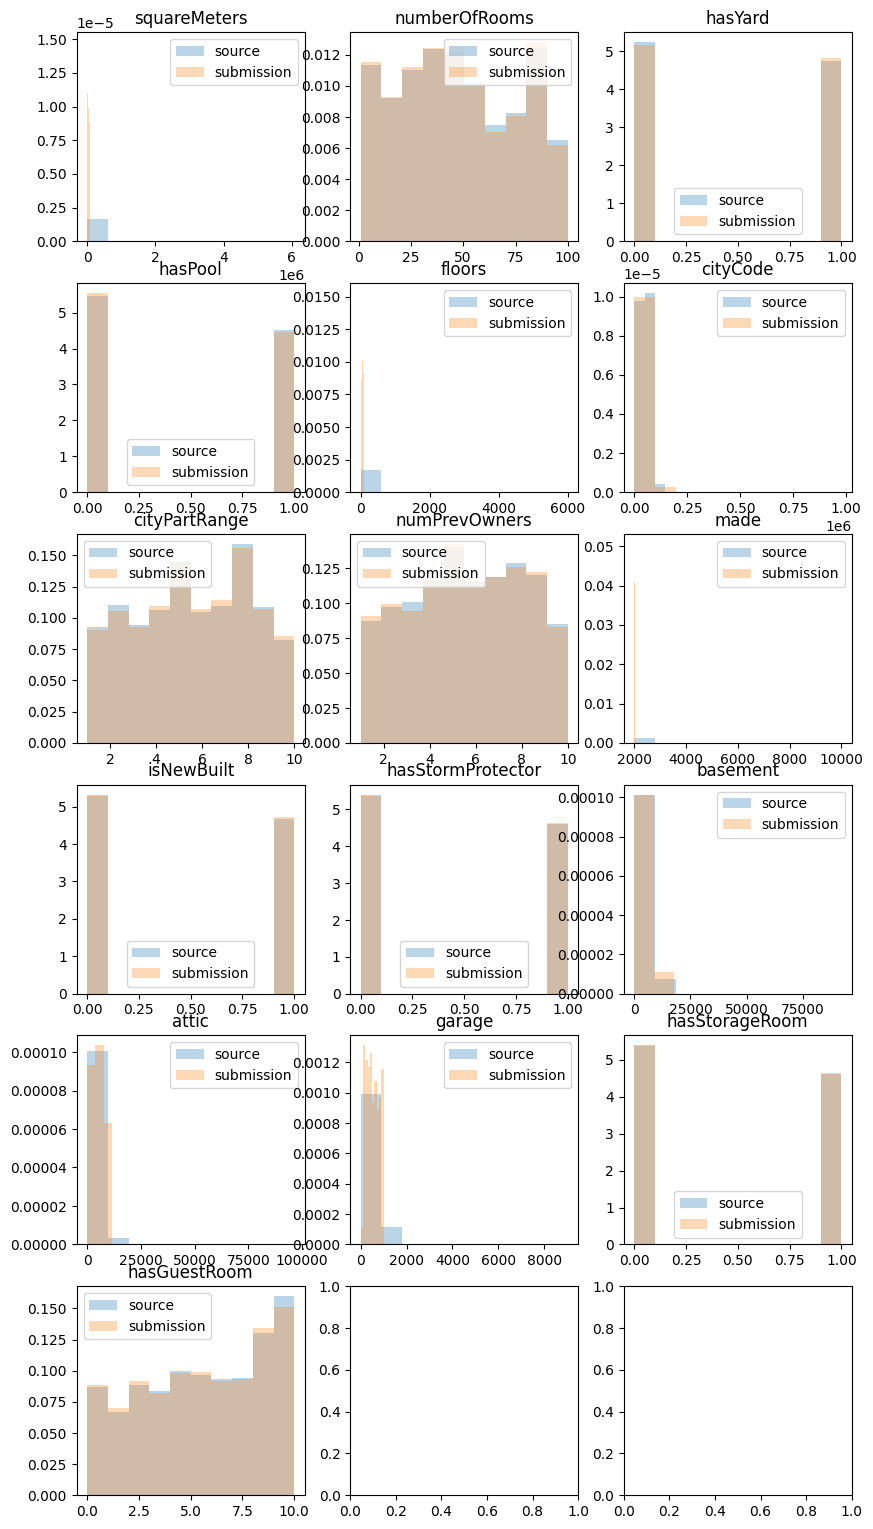

In [ ]:
from sklearn_utils import visualize_datasets_distributions

visualize_datasets_distributions(
    {
        'source': source_df,
        'submission': submission_df
    },
    columns=submission_df.columns
)

In [ ]:
submission_df.made.max(), source_df.made.max()

(2021, 10000)

<Axes: >

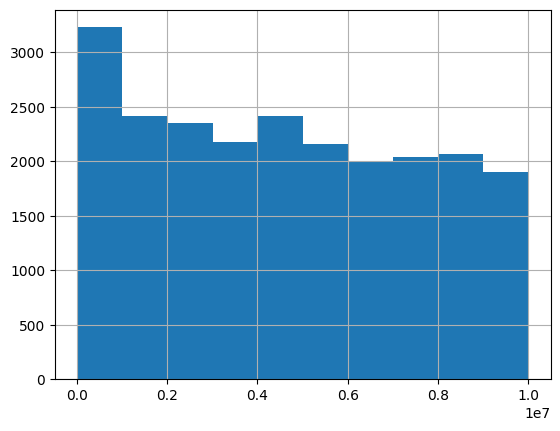

In [ ]:
source_df['price'].hist()

# Clean outliers (on the whole data, before data analysis)

## Source dataset

### Quantile cleaning

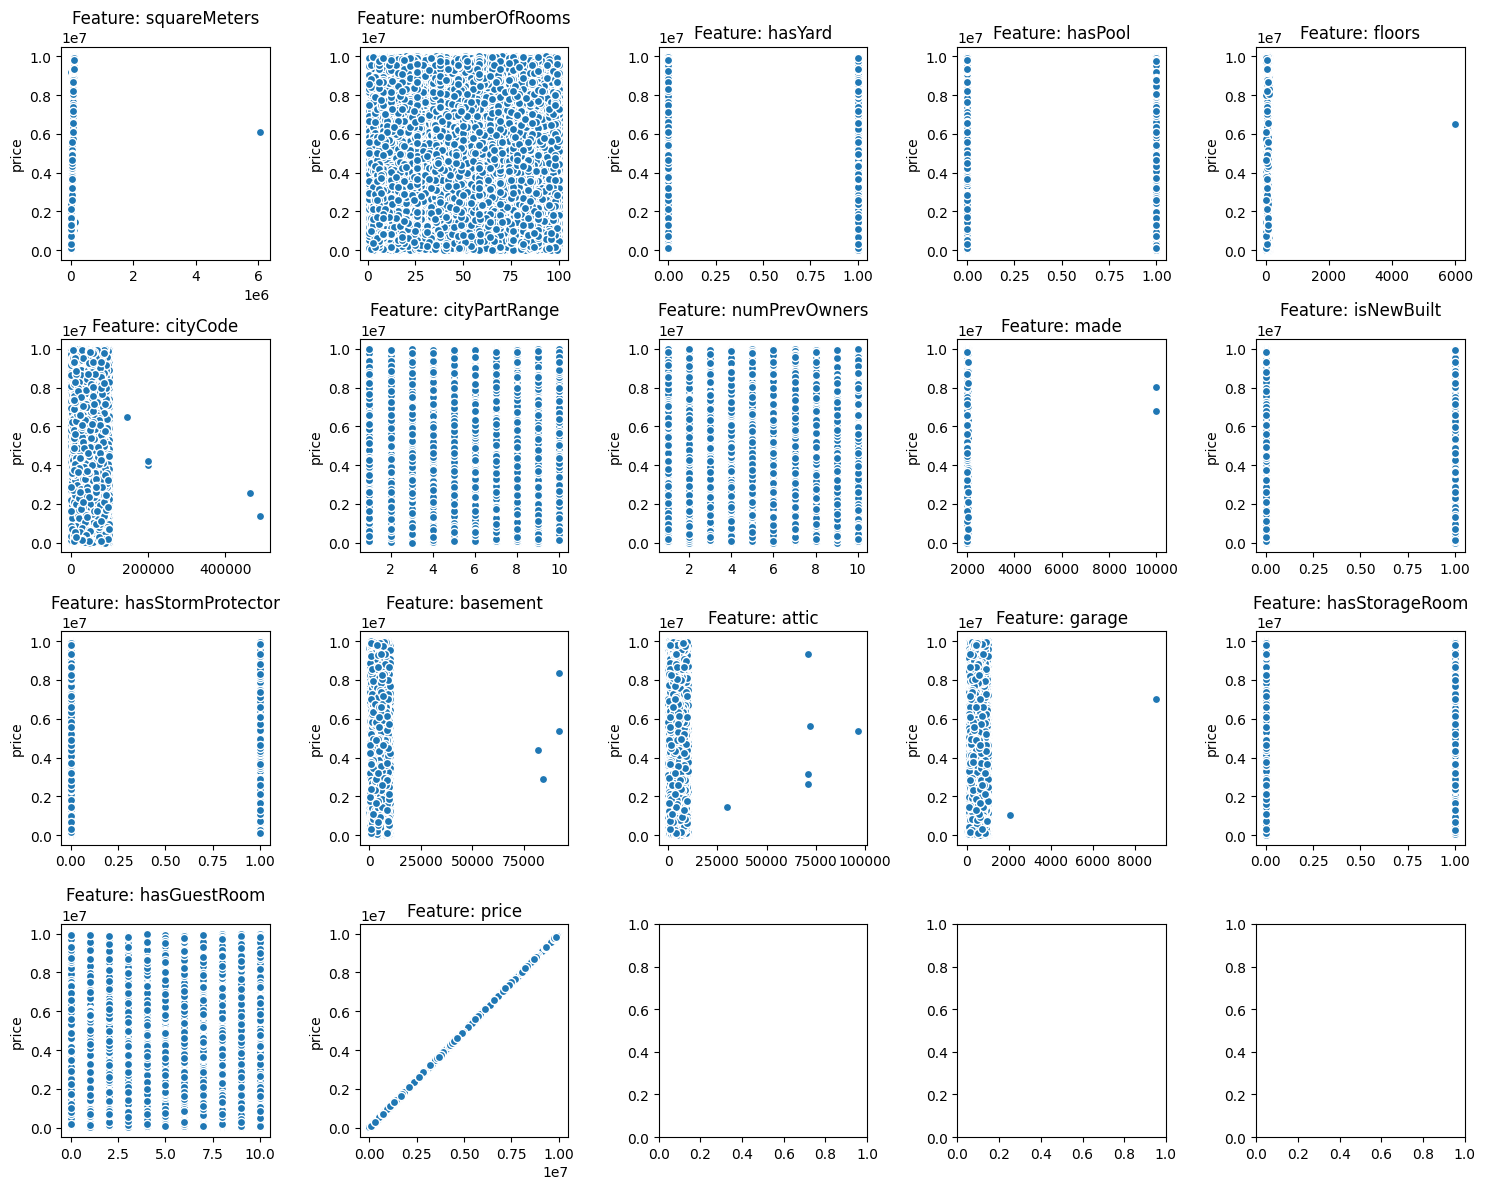

In [92]:
from sklearn_utils import visualize_target_vs_columns

visualize_target_vs_columns(
    source_df,
    target_colname='price',
    columns=source_df.columns
)

For squareMeters: 20 outliers
Indices: [648, 2323, 3184, 3515, 4657, 4741, 5261, 8054, 8533, 10043, 13686, 14864, 15334, 15749, 17330, 17742, 19081, 19438, 19978, 21320]
For floors: 1 outliers
Indices: [5659]
For cityCode: 7 outliers
Indices: [299, 1326, 2425, 10987, 20576, 20735, 22631]
For made: 5 outliers
Indices: [2113, 3608, 19124, 19748, 21400]
For basement: 4 outliers
Indices: [2107, 3995, 15068, 18926]
For attic: 7 outliers
Indices: [3828, 4909, 12858, 13633, 13642, 17168, 19994]
For garage: 2 outliers
Indices: [14878, 17629]
In total: 46 outliers


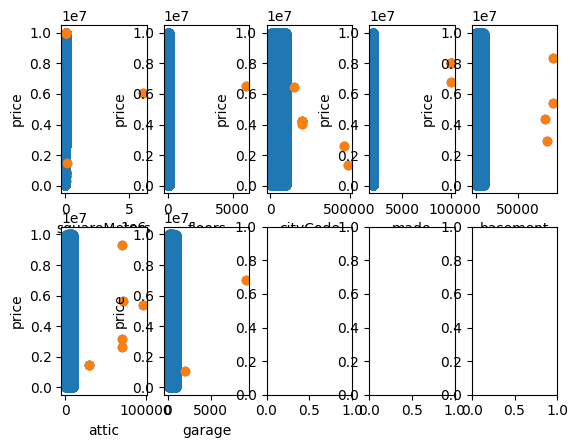

In [93]:
def plot_quantile_outliers(df, column_quantile_dict, n_cols=5):
    temp = len(column_quantile_dict.keys()) // n_cols
    n_rows = temp if len(column_quantile_dict.keys()) % n_cols == 0 else temp + 1

    _, ax = plt.subplots(nrows=n_rows, ncols=n_cols)
    ax = ax.flatten()
    counter = 0
    outlier_indices = list()
    for column_name, quantile in column_quantile_dict.items():

        subset = df.loc[
            df[column_name] > df[column_name].quantile(quantile)
        ]
        print(f'For {column_name}: {subset.shape[0]} outliers')
        print(f'Indices: {list(subset.index)}')

        outlier_indices += list(subset.index)

        ax[counter].scatter(df[column_name], df['price'])
        ax[counter].scatter(subset[column_name], subset['price'])
        ax[counter].set_ylabel('price')
        ax[counter].set_xlabel(column_name)

        counter += 1
    print(f'In total: {len(set(outlier_indices))} outliers')
    return set(outlier_indices)


outlier_indices = plot_quantile_outliers(
    source_df,
    {
        'squareMeters': 0.999,
        'floors': 0.999,
        'cityCode': 0.9997,
        'made': 0.999,
        'basement': 0.9995,
        'attic': 0.9995,
        'garage': 0.999
    }
)

In [94]:
print(f'Data size before IQR cleaning: {source_df.shape}')
source_df = source_df.iloc[~source_df.index.isin(outlier_indices), :]
print(f'Data size after IQR cleaning: {source_df.shape}')

Data size before IQR cleaning: (22730, 17)
Data size after IQR cleaning: (22684, 17)


### Local Outlier Factor cleaning

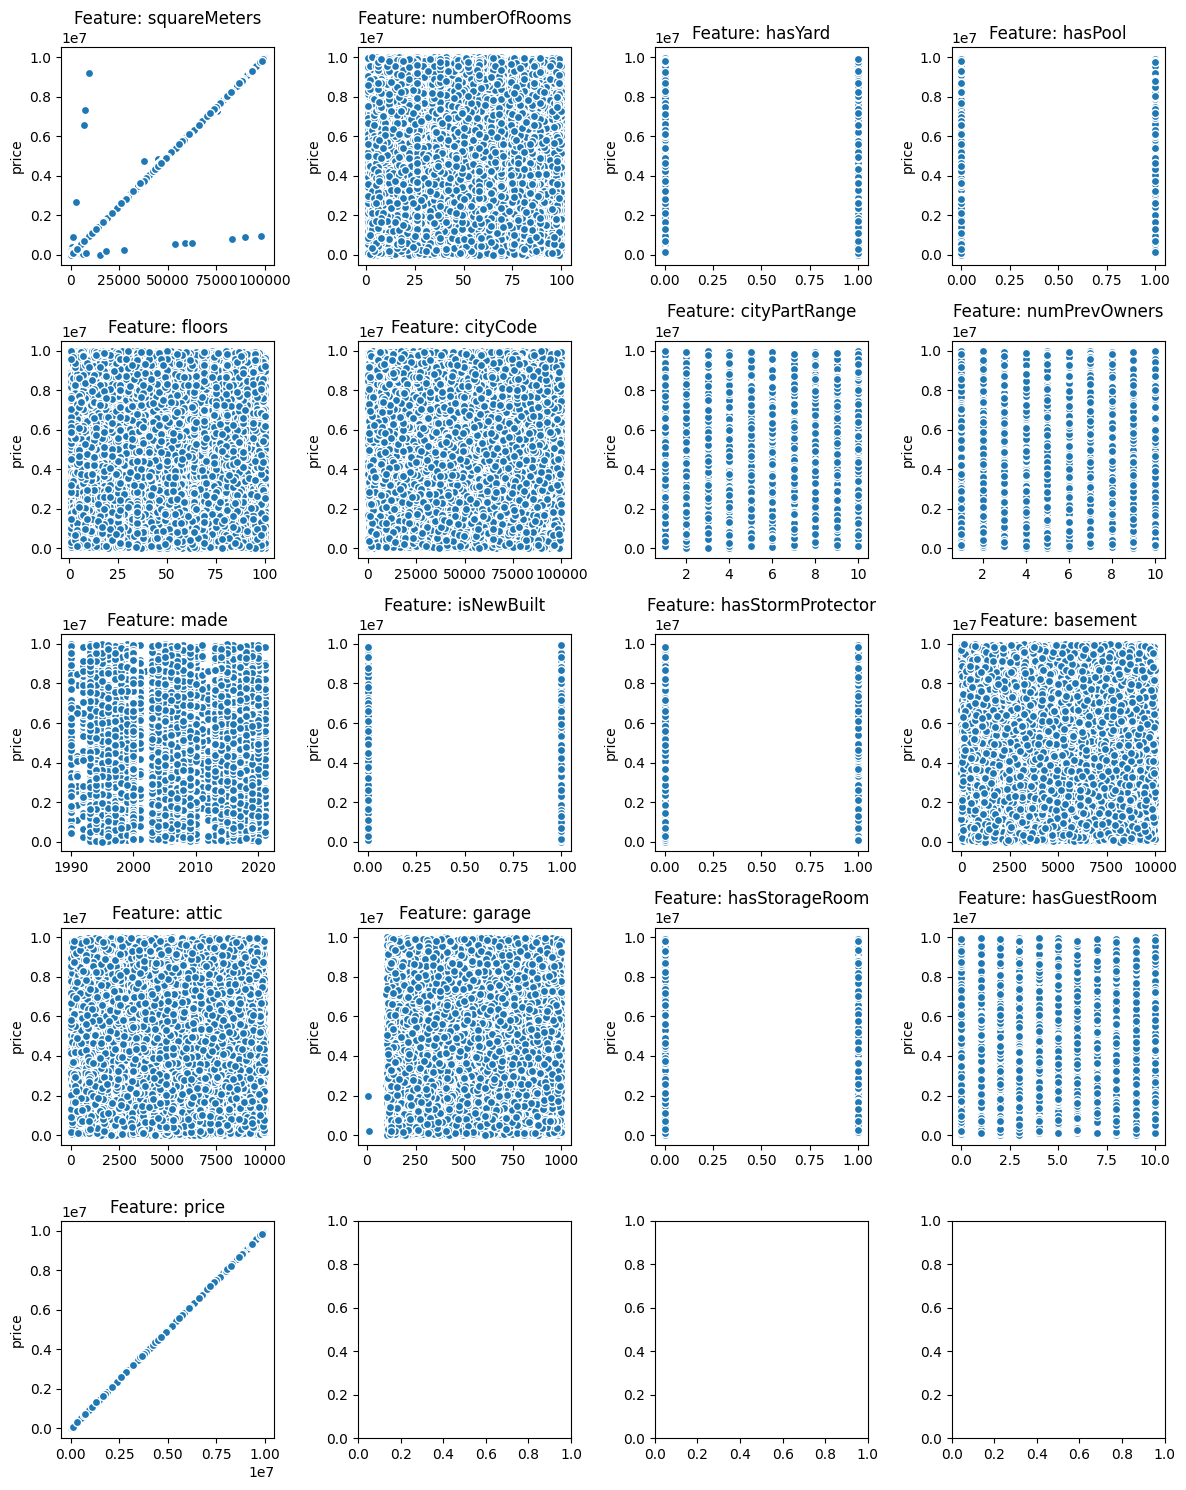

In [95]:
visualize_target_vs_columns(
    source_df,
    'price',
    source_df.columns,
    grid_width=4,
    height_scale=3.0
)

OUTLIERS: 244


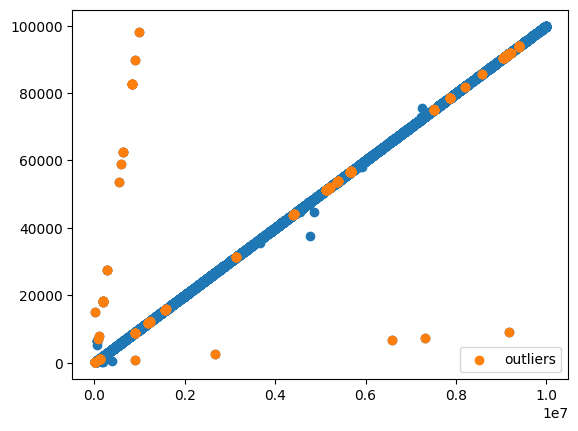

In [96]:
from sklearn.neighbors import LocalOutlierFactor


clf = LocalOutlierFactor(n_neighbors=60)  # 60
preds = clf.fit_predict(source_df[['price', 'squareMeters']])

outlier_indices = np.where(preds == -1)[0]
outlier_subset = source_df.iloc[outlier_indices]

print(f'OUTLIERS: {outlier_subset.shape[0]}')

_, ax = plt.subplots()
ax.scatter(source_df['price'], source_df['squareMeters'])
ax.scatter(outlier_subset['price'], outlier_subset['squareMeters'], label='outliers')
ax.legend()

We will clean (244,) outliers
shape before: (22684, 17)
shape after: (22440, 17)
(22440, 17)


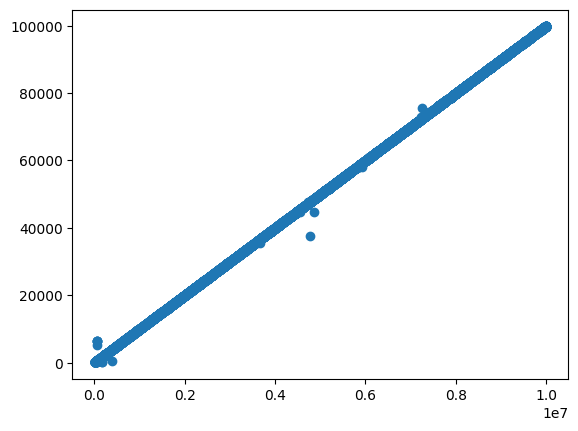

In [97]:


print(f'We will clean {outlier_indices.shape} outliers')

print(f'shape before: {source_df.shape}')
source_df = source_df.iloc[~source_df.index.isin(outlier_subset.index), :]
print(f'shape after: {source_df.shape}')

_, ax = plt.subplots()
ax.scatter(source_df['price'], source_df['squareMeters'])

print(source_df.shape)

## Submission dataset

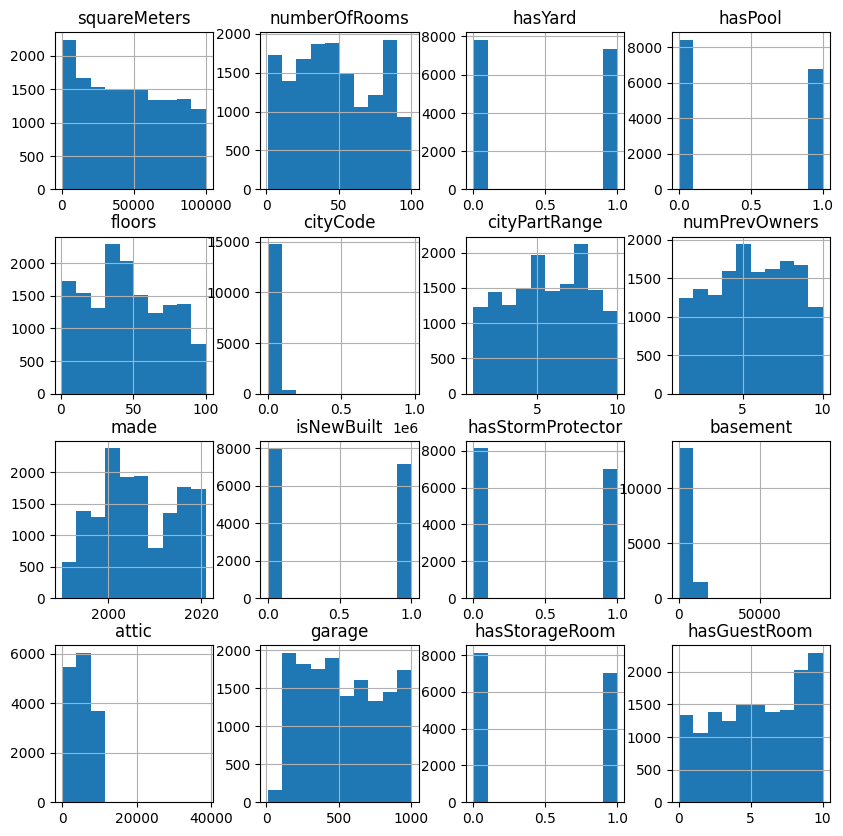

In [98]:
_ = submission_df.hist(figsize=(10, 10))

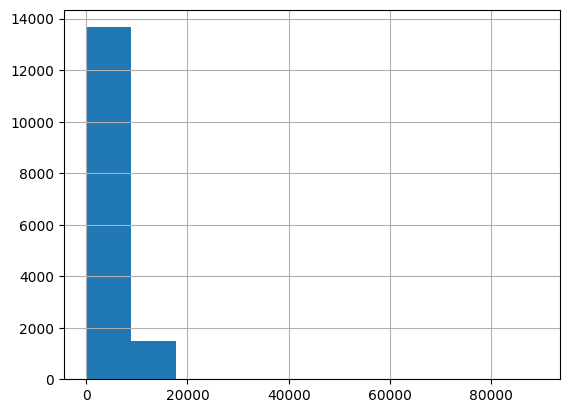

In [99]:
ax = submission_df['basement'].hist()

In [100]:
assert submission_df.isna().sum().sum() == 0, print(submission_df.isna().sum().sum())
submission_df.loc[submission_df['basement'] >= 20000, 'basement'] = 10000

<Axes: >

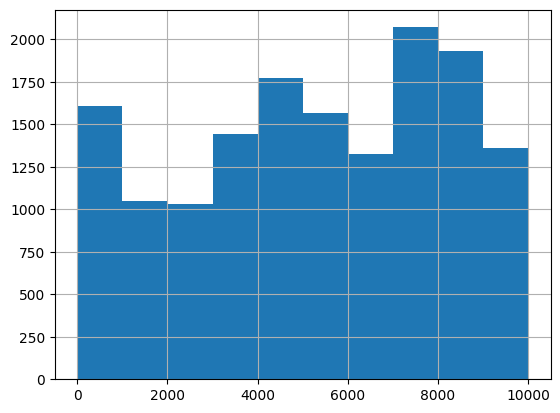

In [101]:
submission_df.basement.hist()

<Axes: >

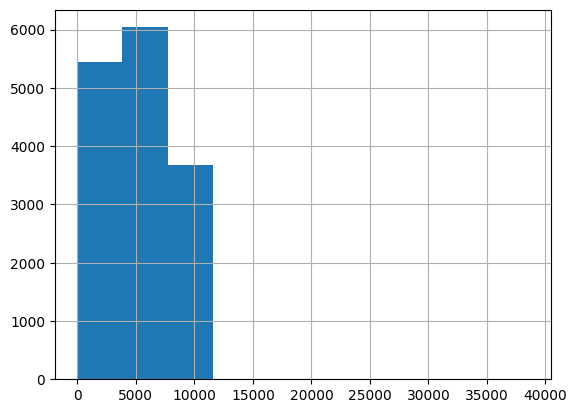

In [102]:
submission_df['attic'].hist()

id
22811    10000
34236    10000
37499    13779
31878    30000
25568    38535
Name: attic, dtype: int64


<Axes: >

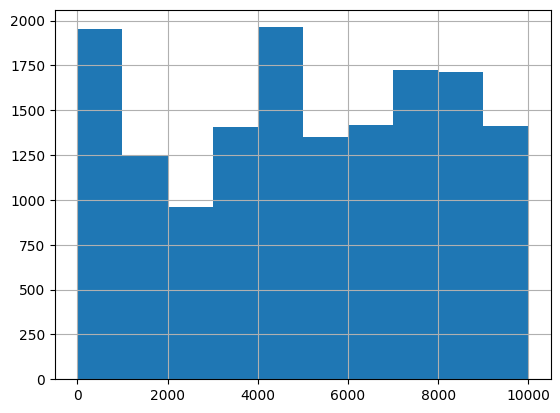

In [103]:
print(submission_df['attic'].sort_values().tail())
submission_df.loc[submission_df['attic'] >= 10000, 'attic'] = 10000
submission_df['attic'].hist()

<Axes: >

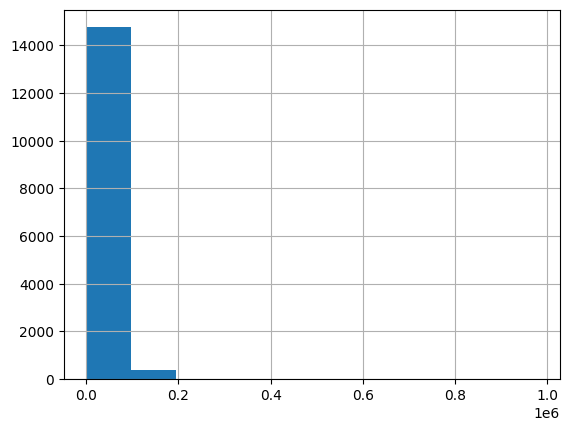

In [104]:
submission_df['cityCode'].hist()

In [105]:
submission_df['cityCode'].sort_values().tail()
submission_df.loc[submission_df['cityCode'] > 99999, 'cityCode'] = submission_df.cityCode.median()

In [106]:
submission_df['cityCode'].sort_values().tail()

id
29286    99940
27437    99953
34187    99953
34707    99953
37705    99999
Name: cityCode, dtype: int64

<Axes: >

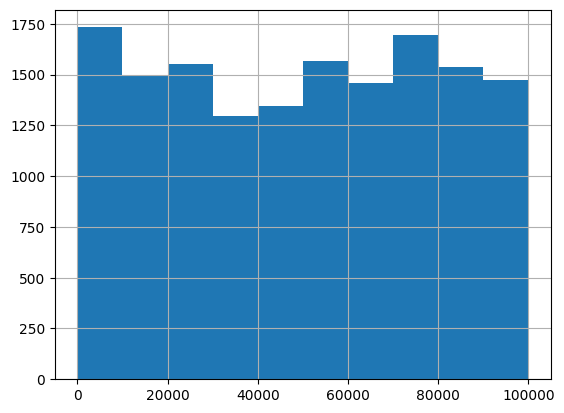

In [107]:
submission_df['cityCode'].hist()

array([[<Axes: title={'center': 'squareMeters'}>,
        <Axes: title={'center': 'numberOfRooms'}>,
        <Axes: title={'center': 'hasYard'}>,
        <Axes: title={'center': 'hasPool'}>],
       [<Axes: title={'center': 'floors'}>,
        <Axes: title={'center': 'cityCode'}>,
        <Axes: title={'center': 'cityPartRange'}>,
        <Axes: title={'center': 'numPrevOwners'}>],
       [<Axes: title={'center': 'made'}>,
        <Axes: title={'center': 'isNewBuilt'}>,
        <Axes: title={'center': 'hasStormProtector'}>,
        <Axes: title={'center': 'basement'}>],
       [<Axes: title={'center': 'attic'}>,
        <Axes: title={'center': 'garage'}>,
        <Axes: title={'center': 'hasStorageRoom'}>,
        <Axes: title={'center': 'hasGuestRoom'}>]], dtype=object)

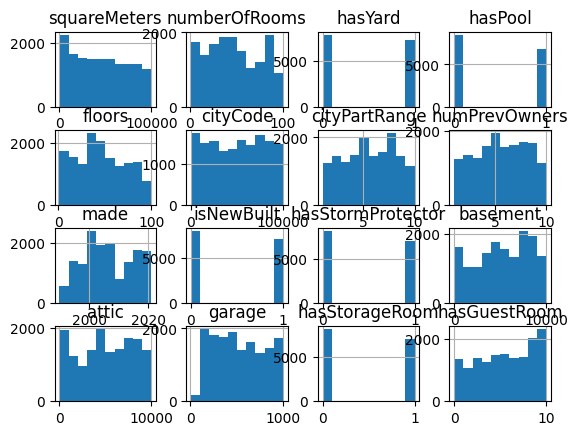

In [108]:
submission_df.hist()

# Data split

In [109]:
from sklearn.model_selection import train_test_split


train_df, validation_df = train_test_split(
    source_df,
    train_size=0.8,
    random_state=42,
)

train_df.shape, validation_df.shape

((17952, 17), (4488, 17))

Visualizing datasets distributions
(6, 3) <class 'numpy.ndarray'>


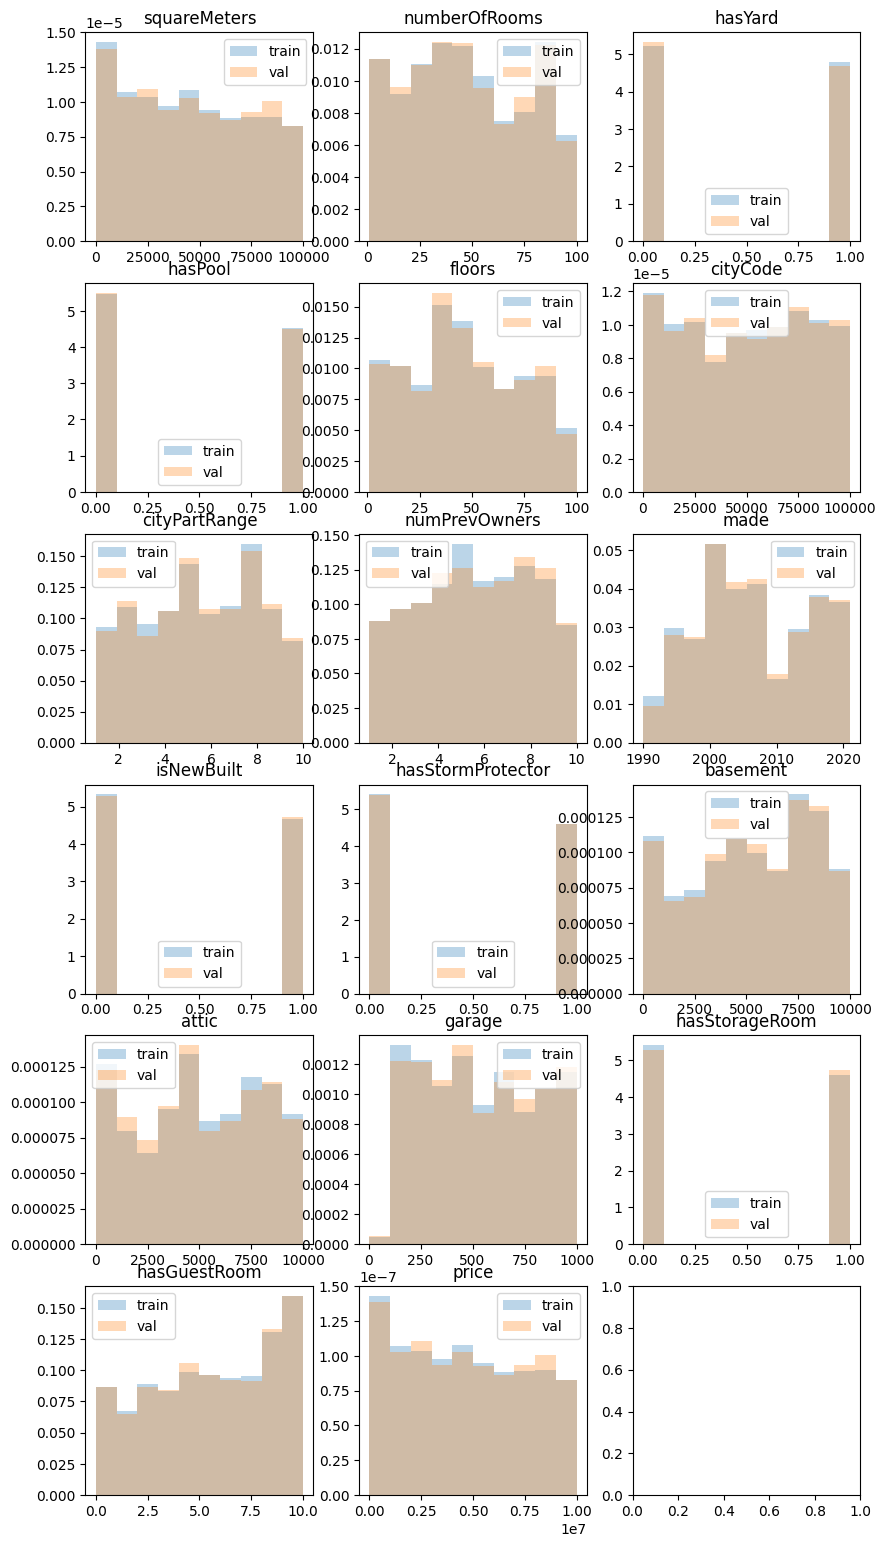

In [110]:
from sklearn_utils import visualize_datasets_distributions

visualize_datasets_distributions(
    {
        'train': train_df,
        'val': validation_df
    },
    columns=train_df.columns  # ['price']
)

# Prepare model

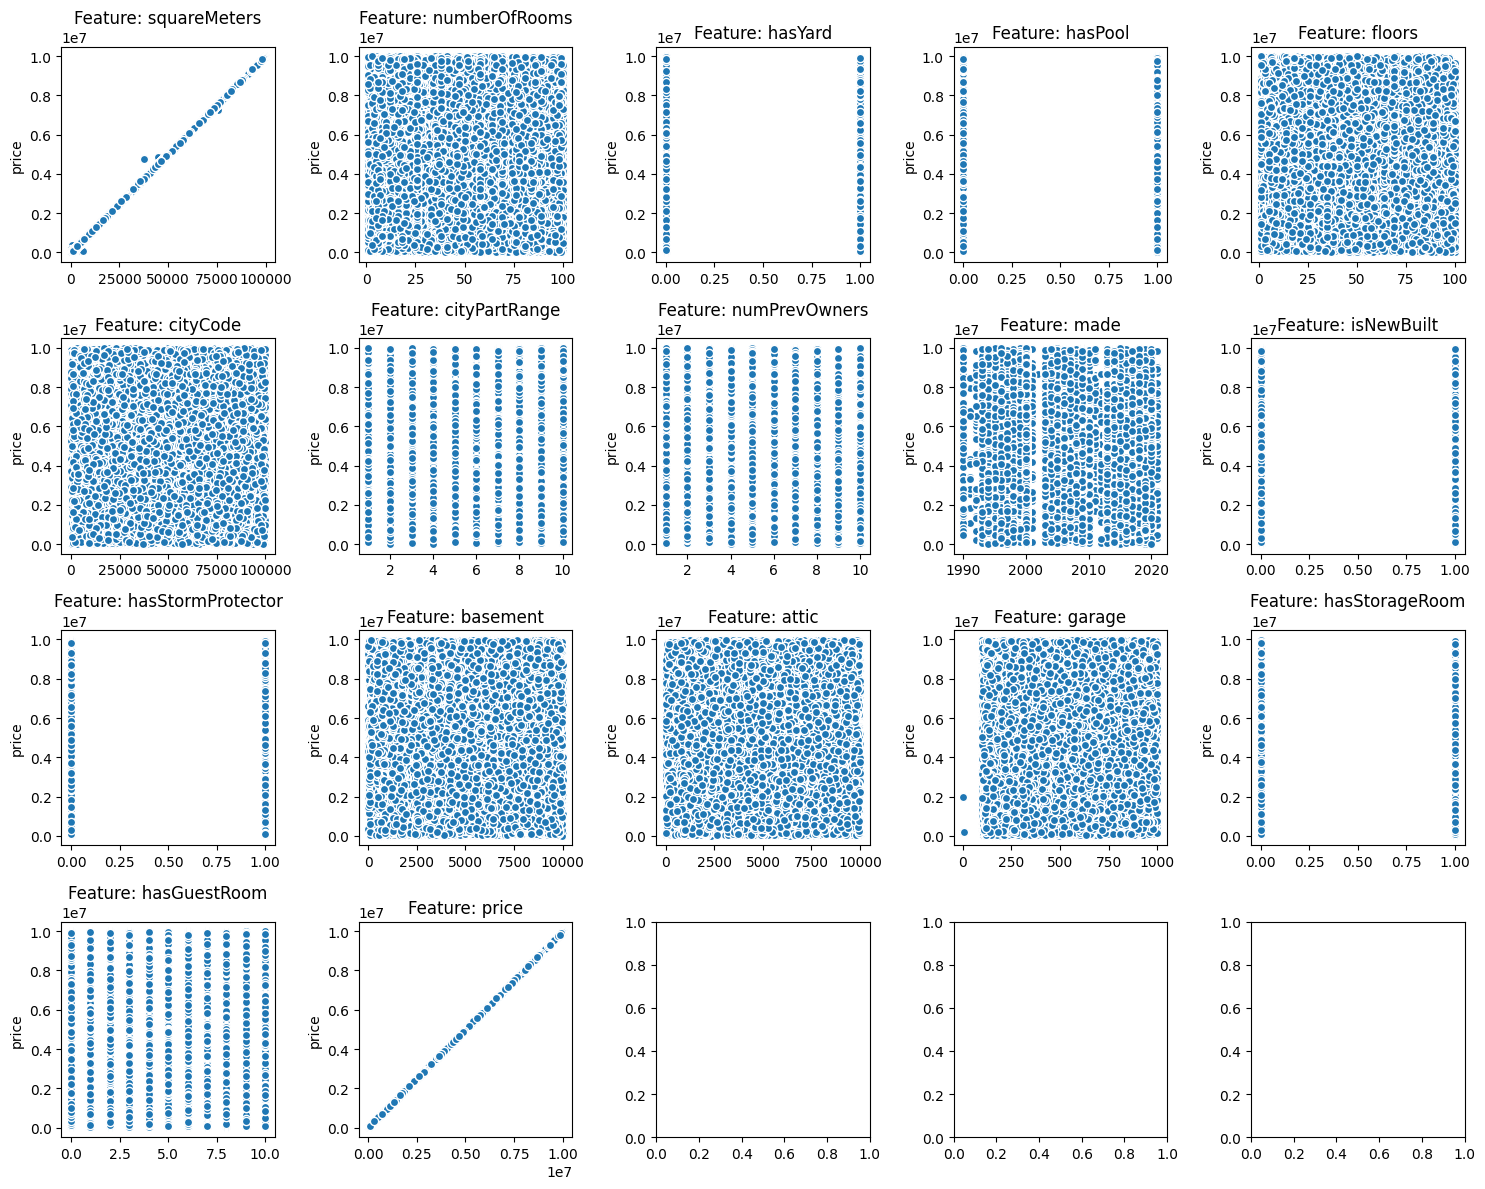

In [111]:
visualize_target_vs_columns(source_df, 'price', source_df.columns)

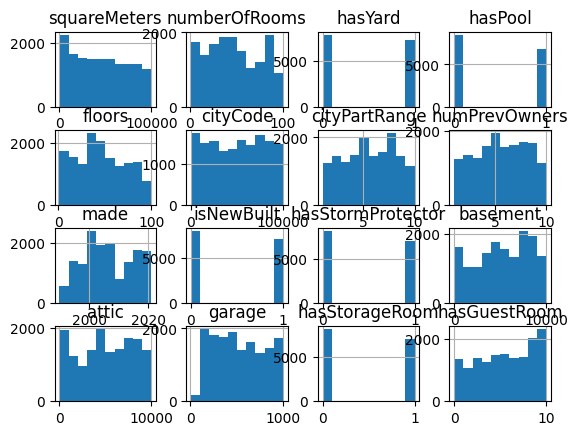

In [112]:
_ = submission_df.hist()

In [113]:
source_df.shape, submission_df.shape

((22440, 17), (15154, 16))

# Prepare and fit model

In [114]:
from autogluon.tabular import TabularPredictor

model = TabularPredictor(
    label='price',
    problem_type='regression',
    eval_metric='root_mean_squared_error',
    path='AutoGluonModels'
)

In [123]:
FEATURES = ['squareMeters','basement','garage','made','cityCode','price']

In [126]:
model.fit(
    train_data=train_df.loc[:, FEATURES],
    tuning_data=validation_df.loc[:, FEATURES],
    time_limit=10*60*60,
    presets=[
        'medium_quality'
    ],
    hyperparameters='light',
    keep_only_best=True,
    save_space=True
)

Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 36000s
AutoGluon will save models to "AutoGluonModels/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   79.80 GB / 115.66 GB (69.0%)
Train Data Rows:    17952
Train Data Columns: 5
Tuning Data Rows:    4488
Tuning Data Columns: 5
Label Column: price
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11157.79 MB
	Train Data (Original)  Memory Usage: 0.9 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFe

[1000]	valid_set's rmse: 57612.2
[2000]	valid_set's rmse: 48788.5
[3000]	valid_set's rmse: 45137.8
[4000]	valid_set's rmse: 43094
[5000]	valid_set's rmse: 41428
[6000]	valid_set's rmse: 40251.9
[7000]	valid_set's rmse: 39187.7
[8000]	valid_set's rmse: 38508.1
[9000]	valid_set's rmse: 38039.3
[10000]	valid_set's rmse: 37545.6


	-37545.5874	 = Validation score   (-root_mean_squared_error)
	35.84s	 = Training   runtime
	14.63s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 35943.53s of the 35943.51s of remaining time.
	-20514.9719	 = Validation score   (-root_mean_squared_error)
	1.76s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 35941.62s of the 35941.6s of remaining time.
	-16969.6492	 = Validation score   (-root_mean_squared_error)
	20.97s	 = Training   runtime
	0.67s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 35918.15s of the 35918.13s of remaining time.
	-20542.8258	 = Validation score   (-root_mean_squared_error)
	201.86s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTreesMSE ... Training model for up to 35716.18s of the 35716.17s of remaining time.
	-16379.9223	 = Validation score   (-root_mean_squared_error)
	4.15s	 = Training   runtime
	0.28s	 = Validat

In [127]:
leaderboard = model.leaderboard()
leaderboard.head()

                 model     score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2 -16364.326235      15.764685  104.051344                0.000862           0.433266            2       True          6
1        ExtraTreesMSE -16379.922305       0.280959    4.153357                0.280959           4.153357            1       True          4
2      RandomForestMSE -16969.649167       0.666177   20.974916                0.666177          20.974916            1       True          3
3             LightGBM -20514.971948       0.089098    1.761214                0.089098           1.761214            1       True          2
4      NeuralNetFastAI -21998.111256       0.093777   40.885712                0.093777          40.885712            1       True          5
5           LightGBMXT -37545.587419      14.633811   35.842880               14.633811          35.842880            1       True          1


,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-16364.326235,15.764685,104.051344,0.000862,0.433266,2,True,6
1,ExtraTreesMSE,-16379.922305,0.280959,4.153357,0.280959,4.153357,1,True,4
2,RandomForestMSE,-16969.649167,0.666177,20.974916,0.666177,20.974916,1,True,3
3,LightGBM,-20514.971948,0.089098,1.761214,0.089098,1.761214,1,True,2
4,NeuralNetFastAI,-21998.111256,0.093777,40.885712,0.093777,40.885712,1,True,5


# Creating a submission file

In [128]:
submission_df.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
id,,,,,,,,,,,,,,,,
22730,47580,89,0,1,8,54830,5,3,1995,0,0,6885,8181,241,0,8
22731,62083,38,0,0,87,8576,10,3,1994,1,1,4601,9237,393,1,4
22732,90499,75,1,1,37,62454,9,6,1997,0,1,7454,2680,305,0,2
22733,16354,47,1,1,9,9262,6,5,2019,1,1,705,5097,122,1,5
22734,67510,8,0,0,55,24112,3,7,2014,1,1,3715,7979,401,1,9


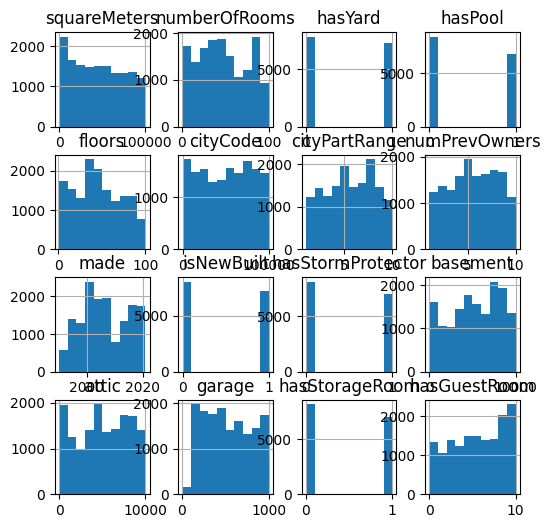

In [130]:
_ = submission_df.hist(figsize=(6, 6))

In [131]:
pred = model.predict(submission_df)

In [132]:
pred

id
22730    4763186.500
22731    6215689.500
22732    9058579.000
22733    1645169.625
22734    6758727.500
            ...     
37879    8624978.000
37880    4592755.500
37881    7358432.000
37882    7766826.500
37883    1823899.000
Name: price, Length: 15154, dtype: float32

In [133]:
submissions_file = pd.DataFrame(
    {
        'id': submission_df.index,
        'price': pred
    }
)

submissions_file.head()

,id,price
id,,
22730,22730,4763186.500
22731,22731,6215689.500
22732,22732,9058579.000
22733,22733,1645169.625
22734,22734,6758727.500


In [134]:
manager.data_trial_path

'/content/gdrive/MyDrive/ML/Competitions/10.ParisHousePrices/Data/preproc_trial_autogluon'

In [135]:
submissions_file.to_csv(
    f'{manager.data_trial_path}/submission.csv',
    index=False
)